<img src="http://oproject.org/tiki-download_file.php?fileId=8&display&x=450&y=128">
<img src="http://files.oproject.org/tmvalogo.png" height="50%" width="50%">

# TMVA  Cross Validation Example 

#### Example of training TMVA using Cross Validation

#### Provide Input file

In [1]:
TString inputFileName = "Higgs_data.root";

//TString inputFileName = "tmva_class_example.root";

auto inputFile = TFile::Open( inputFileName );

## Declare Factory

Create the Factory class. Later you can choose the methods
whose performance you'd like to investigate. 

The factory is the major TMVA object you have to interact with. Here is the list of parameters you need to pass

 - The first argument is the base of the name of all the output
weightfiles in the directory weight/ that will be created with the 
method parameters 

 - The second argument is the output file for the training results
  
 - The third argument is a string option defining some general configuration for the TMVA session. For example all TMVA output can be suppressed by removing the "!" (not) in front of the "Silent" argument in the option string

In [2]:
TMVA::Tools::Instance();


auto outputFile = TFile::Open("Higgs_CrossValidationOutput.root", "RECREATE");

//TMVA::Factory factory("TMVAClassification", outputFile,
//                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" ); 

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input variables 

Define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In [3]:
TMVA::DataLoader * loader = new TMVA::DataLoader("dataset");

loader->AddVariable("m_jj");
loader->AddVariable("m_jjj");
loader->AddVariable("m_lv");
loader->AddVariable("m_jlv");
loader->AddVariable("m_bb");
loader->AddVariable("m_wbb");
loader->AddVariable("m_wwbb");

## Setup Dataset(s)

Define input data file and signal and background trees

In [4]:
// --- Register the training and test trees

TTree *signalTree     = (TTree*)inputFile->Get("sig_tree");
TTree *backgroundTree = (TTree*)inputFile->Get("bkg_tree");

// global event weights per tree (see below for setting event-wise weights)
Double_t signalWeight     = 1.0;
Double_t backgroundWeight = 1.0;
   
// You can add an arbitrary number of signal or background trees
loader->AddSignalTree    ( signalTree,     signalWeight     );
loader->AddBackgroundTree( backgroundTree, backgroundWeight );


// Set individual event weights (the variables must exist in the original TTree)
//    for signal    : factory->SetSignalWeightExpression    ("weight1*weight2");
//    for background: factory->SetBackgroundWeightExpression("weight1*weight2");
//loader->SetBackgroundWeightExpression( "weight" );

// Apply additional cuts on the signal and background samples (can be different)
TCut mycuts = ""; // for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
TCut mycutb = ""; // for example: TCut mycutb = "abs(var1)<0.5";

// Tell the factory how to use the training and testing events
//
// If no numbers of events are given, half of the events in the tree are used 
// for training, and the other half for testing:
//    loader->PrepareTrainingAndTestTree( mycut, "SplitMode=random:!V" );
// To also specify the number of testing events, use:

loader->PrepareTrainingAndTestTree( mycuts, mycutb,
                                    "nTrain_Signal=0:nTrain_Background=0:SplitMode=Random:NormMode=NumEvents:!V" );



//loader->PrepareTrainingAndTestTree(mycuts, mycutb,
//                                   "nTrain_Signal=5000:nTrain_Background=5000:nTest_Signal=5000:nTest_Background=5000:SplitMode=Random:NormMode=NumEvents:!V" ); 


DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 10000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 10000 events


# Run Cross Validation

In [5]:
// needed for master version
//TString cvOptions = "!V:!Silent:ModelPersistence:AnalysisType=Classification:NumFolds=5";
//                    ":SplitExpr=""";

In [5]:
//TMVA::CrossValidation cv("TMVACrossValidation",loader,cvOptions);
auto cv = new TMVA::CrossValidation(loader); 

In [6]:


// Fisher discriminant (same as LD)
cv->BookMethod(TMVA::Types::kFisher, "Fisher", "H:!V:Fisher:VarTransform=None:CreateMVAPdfs:PDFInterpolMVAPdf=Spline2:NbinsMVAPdf=50:NsmoothMVAPdf=10" );


//Boosted Decision Trees
cv->BookMethod(TMVA::Types::kBDT, "BDT",
                   "!V:NTrees=200:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" );

//Multi-Layer Perceptron (Neural Network)
//factory.BookMethod(loader, TMVA::Types::kMLP, "MLP",
//                   "!H:!V:NeuronType=tanh:VarTransform=N:NCycles=100:HiddenLayers=N+5:TestRate=5:!UseRegulator" );

### Do CrossValidation: Train/Test  Booked Method

In [7]:
cv->Evaluate(); 

                         : Evaluate method: Fisher


0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time 

                         : Evaluate method: BDT


0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time 

                         : Evaluation done.


## Cross Validation Result

In [10]:
TMVA::CrossValidationResult & result = (TMVA::CrossValidationResult &) cv->GetResults()[0];

result.Print();

  

<HEADER> CrossValidation          :  ==== Results ====
                         : Fold  0 ROC-Int : 0.6493
                         : Fold  1 ROC-Int : 0.6565
                         : Fold  2 ROC-Int : 0.6501
                         : Fold  3 ROC-Int : 0.6500
                         : Fold  4 ROC-Int : 0.6386
                         : ------------------------
                         : Average ROC-Int : 0.6489
                         : Std-Dev ROC-Int : 0.0065


## Plot ROC Curve
We enable JavaScript visualisation for the plots

In [ ]:
%jsroot on

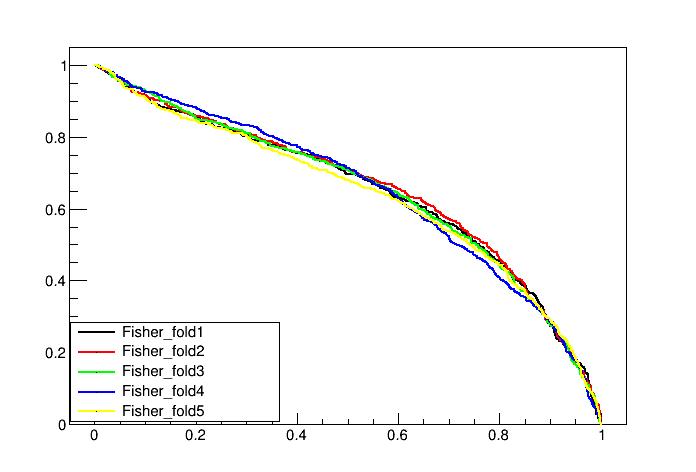

In [11]:
auto c = new TCanvas();
result.GetROCCurves()->Draw("AL");
c->BuildLegend();
c->Draw();

In [12]:
// close outputfile to save output file
outputFile->Close()